In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
# Load CSV files\
df_data = pd.read_csv('pandas/df_data.csv', low_memory=False)
df_filtered = pd.read_csv('pandas/df_filtered.csv')

agg_df = pd.read_csv('pandas/agg_df_cluster.csv')
fish_df = pd.read_csv('pandas/fish_df_cluster.csv')
agg_df_large = pd.read_csv('pandas/agg_df_large_cluster.csv')
fish_df_large = pd.read_csv('pandas/fish_df_large_cluster.csv')

In [98]:
# designate which clustering to analyze
df_explore = agg_df # or agg_df_large
fish_explore = fish_df # or fish_df_large

In [90]:
# Specify cluster to analyze
cluster_num = 1

# Filter data for this cluster
cluster_data = df_explore[df_explore['cluster'] == cluster_num]
cluster_fish_data = df_filtered[df_filtered['barcode'].isin(cluster_data['barcode'])]

# Environmental variables summary (median)
env_vars = ['median_temp', 'median_depth', 'median_current', 'median_esveg92', 'median_cond']
env_summary = cluster_data[env_vars].median()

# Categorical variables summary (mode)
cat_vars = ['mode_substrt']
cat_summary = cluster_data[cat_vars].mode().iloc[0]

# Binary variables summary (proportion present)
binary_vars = ['snag_present', 'riprap_present', 'inout_present', 'flooded_present']
binary_summary = cluster_data[binary_vars].mean()

# Fish species counts
fish_in_cluster = fish_explore[df_explore['cluster'] == cluster_num].drop(columns=['cluster'])
species_counts = fish_in_cluster.sum().sort_values(ascending=False)
species_counts = species_counts[species_counts > 0]

cluster_barcodes = df_explore[df_explore['cluster'] == cluster_num]['barcode']

# Total individuals caught
fish_abundance = df_filtered[df_filtered['barcode'].isin(cluster_barcodes)].groupby('fishcode').size()
fish_length = cluster_fish_data.groupby('fishcode')['length'].mean()
#fish_weight = cluster_fish_data.groupby('fishcode')['weight'].mean()

# Number of samples where present
fish_occurrence = fish_in_cluster.sum()

# Combine
species_summary = pd.DataFrame({
    'total_caught': fish_abundance,
    'samples': fish_occurrence,
    'mean_length': round(fish_length,1),
#    'mean_weight': fish_weight
}).fillna(0).astype({'total_caught': int, 'samples': int})
species_summary = species_summary[species_summary['samples'] > 0].sort_values('samples', ascending=False)

# Print summary
print(f"=== CLUSTER {cluster_num} SUMMARY ===")
print(f"\nTotal samples (identified by barcode): {len(cluster_data)}")
print("\n--- Environmental Variables (Median) ---")
print(env_summary)
print("\n--- Categorical Variables (Mode) ---")
print(cat_summary)
print("\n--- Binary Variables (Proportion Present) ---")
print(binary_summary)
print(f"\n--- Fish Species (Count of {len(cluster_data)} samples) ---")
print(species_summary)

=== CLUSTER 1 SUMMARY ===

Total samples (identified by barcode): 6

--- Environmental Variables (Median) ---
median_temp         9.500
median_depth        1.600
median_current      0.165
median_esveg92      0.000
median_cond       391.500
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    2.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       0.833333
riprap_present     0.166667
inout_present      0.000000
flooded_present    0.000000
dtype: float64

--- Fish Species (Count of 6 samples) ---
      total_caught  samples  mean_length
CARP            40        6        548.3
SGER            10        6        218.5
FWDM             7        5        249.4
SMBF             9        5        433.6
WTBS             3        3        114.0
ERSN            19        3         60.6
SHRH             5        3        165.4
SVLP             2        2        267.0
SMBS             6        2        211.8
SFSN             4        2         

In [91]:
# Summarize all clusters at once
for cluster_num in sorted(df_explore['cluster'].unique()):
    cluster_data = df_explore[df_explore['cluster'] == cluster_num]
    cluster_fish_data = df_data[df_data['barcode'].isin(cluster_data['barcode'])]
    
    # Environmental variables summary (median)
    env_vars = ['median_temp', 'median_depth', 'median_current', 'median_esveg92', 'median_cond']
    env_summary = cluster_data[env_vars].median()

    # Categorical variables summary (mode)
    cat_vars = ['mode_substrt']
    cat_summary = cluster_data[cat_vars].mode().iloc[0]

    # Binary variables summary (proportion present)
    binary_vars = ['snag_present', 'riprap_present', 'inout_present', 'flooded_present']
    binary_summary = cluster_data[binary_vars].mean()

    # Fish species counts
    fish_in_cluster = fish_explore[df_explore['cluster'] == cluster_num].drop(columns=['cluster'])
    species_counts = fish_in_cluster.sum().sort_values(ascending=False)
    species_counts = species_counts[species_counts > 0]

    cluster_barcodes = df_explore[df_explore['cluster'] == cluster_num]['barcode']

    # Total individuals caught
    fish_abundance = df_filtered[df_filtered['barcode'].isin(cluster_barcodes)].groupby('fishcode').size()
    fish_length = cluster_fish_data.groupby('fishcode')['length'].mean()
    #fish_weight = cluster_fish_data.groupby('fishcode')['weight'].mean()

    # Number of samples where present
    fish_occurrence = fish_in_cluster.sum()

    # Combine
    species_summary = pd.DataFrame({
        'total_caught': fish_abundance,
        'samples': fish_occurrence,
        'mean_length': round(fish_length,1),
#    'mean_weight': fish_weight
    }).fillna(0).astype({'total_caught': int, 'samples': int})
    species_summary = species_summary[species_summary['samples'] > 0].sort_values('samples', ascending=False)


    # Print summary
    print(f"=== CLUSTER {cluster_num} SUMMARY ===")
    print(f"\nTotal samples (identified by barcode): {len(cluster_data)}")
    print("\n--- Environmental Variables (Median) ---")
    print(env_summary)
    print("\n--- Categorical Variables (Mode) ---")
    print(cat_summary)
    print("\n--- Binary Variables (Proportion Present) ---")
    print(binary_summary)
    print(f"\n--- Fish Species (Count of {len(cluster_data)} samples) ---")
    print(species_summary)

=== CLUSTER 1 SUMMARY ===

Total samples (identified by barcode): 6

--- Environmental Variables (Median) ---
median_temp         9.500
median_depth        1.600
median_current      0.165
median_esveg92      0.000
median_cond       391.500
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    2.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       0.833333
riprap_present     0.166667
inout_present      0.000000
flooded_present    0.000000
dtype: float64

--- Fish Species (Count of 6 samples) ---
      total_caught  samples  mean_length
CARP            40        6        548.3
SGER            10        6        218.5
FWDM             7        5        249.4
SMBF             9        5        433.6
WTBS             3        3        114.0
ERSN            19        3         60.6
SHRH             5        3        165.4
SVLP             2        2        267.0
SMBS             6        2        211.8
SFSN             4        2         

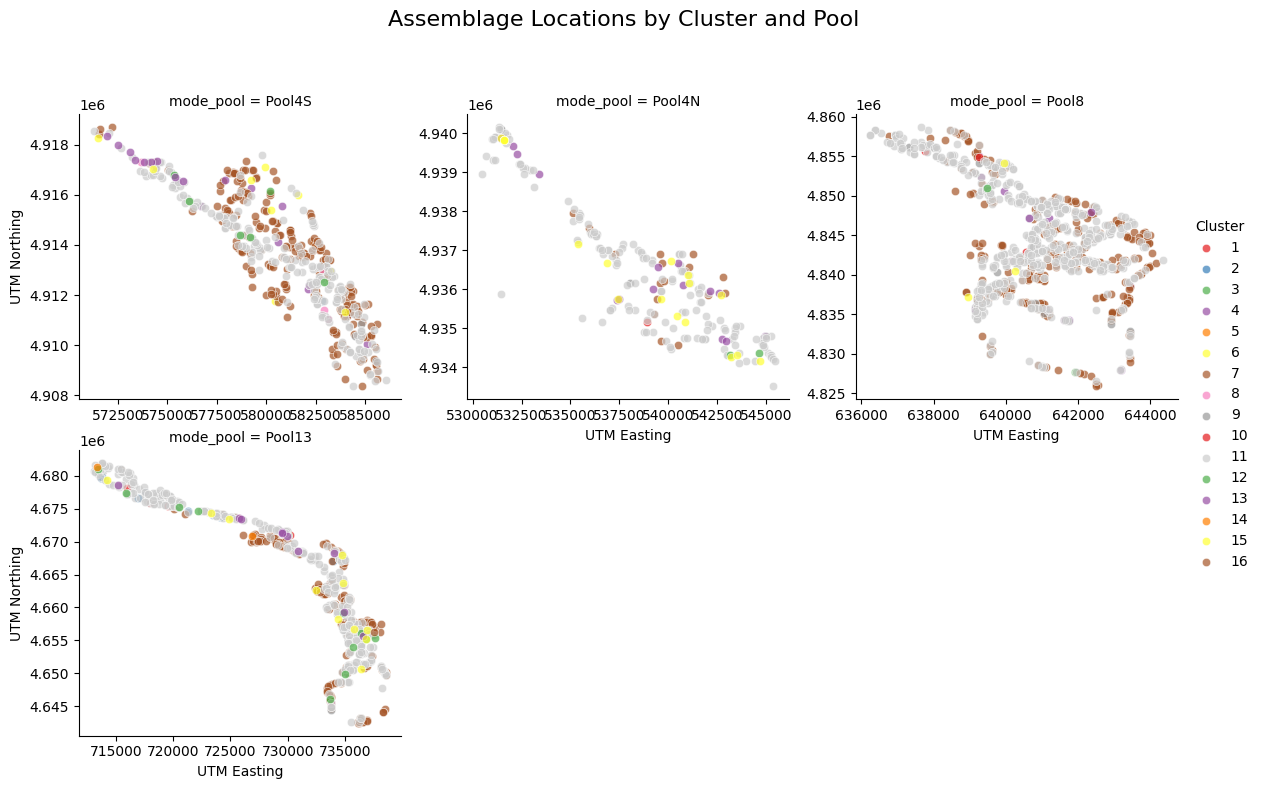

In [92]:
# Find the cluster with the largest count
cluster_sizes = df_explore['cluster'].value_counts()
largest_cluster = df_explore['cluster'].value_counts().idxmax()
unique_clusters = sorted(df_explore['cluster'].unique())
size_map = {c: f"{cluster_sizes[c]} sites" for c in unique_clusters}
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {c: col for c, col in zip(unique_clusters, palette)}
color_map[largest_cluster] = light_color

g = sns.FacetGrid(
    df_explore,
    col="mode_pool",
    hue="cluster",
    palette=color_map,
    col_wrap=3,
    height=4,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Assemblage Locations by Cluster and Pool", fontsize=16)
plt.show()

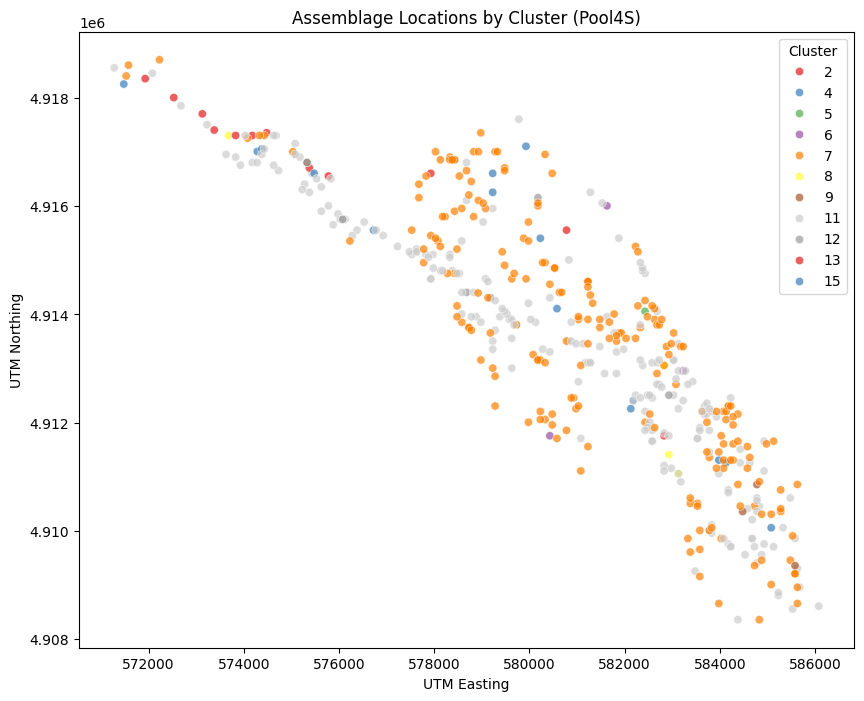

In [97]:
# Filter by specified pool
pool_filter = 'Pool4S'  # Change this to desired pool value
available_pools = sorted(df_explore['mode_pool'].unique().tolist())

if pool_filter not in available_pools:
    print(f"No rows for mode_pool == {pool_filter}. Available pools: {available_pools}")
else:
    df_pool = df_explore[df_explore['mode_pool'] == pool_filter].copy()
    
    # Get cluster info for this pool
    cluster_sizes_pool = df_pool['cluster'].value_counts()
    unique_clusters_pool = sorted(df_pool['cluster'].unique())
    
    # Create color palette
    palette = sns.color_palette("Set1", n_colors=len(unique_clusters_pool))
    light_color = (0.8, 0.8, 0.8)
    color_map = {c: col for c, col in zip(unique_clusters_pool, palette)}
    
    # Set largest cluster to light gray
    if not cluster_sizes_pool.empty:
        largest_cluster_pool = cluster_sizes_pool.idxmax()
        color_map[largest_cluster_pool] = light_color
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_pool,
        x="utm_e",
        y="utm_n",
        hue="cluster",
        palette=color_map,
        alpha=0.7
    )
    plt.xlabel("UTM Easting")
    plt.ylabel("UTM Northing")
    plt.title(f"Assemblage Locations by Cluster ({pool_filter})")
    plt.legend(title="Cluster")
    plt.show()

## <a id='toc2_2_'></a>[Cluster Characteristics](#toc0_)

We next inspected how each cluster varied in it’s species composition.

We will produce three vertical heatmaps for the Jaccard clustering method. Each heatmap shows the average percent presence of each fish species (rows) within each cluster (columns).

*What the graph means:*

-   **Columns**: Each column is a cluster of assemblages (sites grouped by fish community similarity).
-   **Rows**: Each row is a fish species (only those present in >10% of any cluster).
-   **Cell values**: The number in each cell is the percent of assemblages in that cluster where the species is present (0–100%).
-   **Color**: Darker blue = higher percent presence.
-   **Interpretation**: You can see which species are common or rare in each cluster, and how species composition differs between clusters and clustering methods.

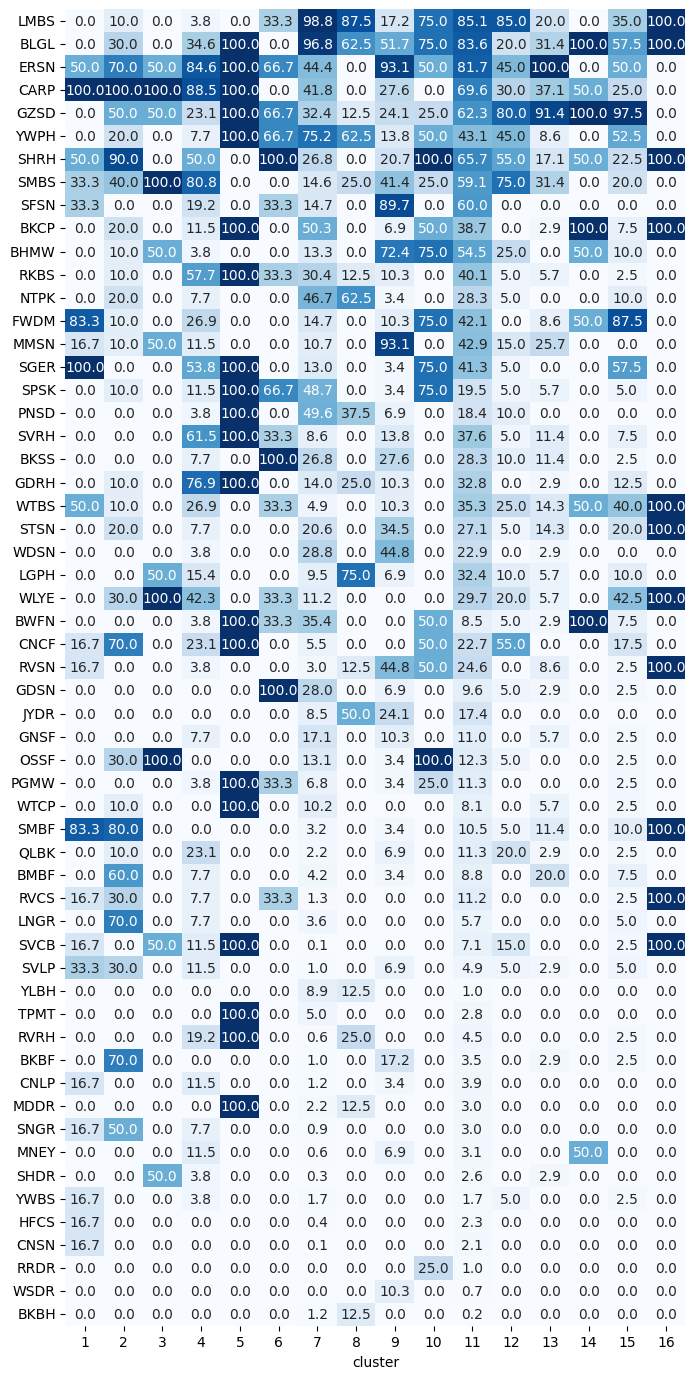

In [94]:
# Order species by overall frequency of occurrence (sum across columns)
species_cols = [c for c in fish_explore.columns if c != 'cluster']
species_order = fish_explore[species_cols].sum(axis=0).sort_values(ascending=False).index.tolist()

# Compute percent presence per cluster
jac_comp = fish_explore.groupby('cluster')[species_order].mean() * 100

# Keep species present in >10% of at least one cluster
filt = jac_comp.max() > 10
jac_comp = jac_comp.loc[:, filt]

# Plot heatmap (species as rows)
plt.figure(figsize=(8, 0.3 * jac_comp.shape[1]))
sns.heatmap(jac_comp.T, cmap='Blues', annot=True, fmt=".1f", cbar=False)
plt.show()

Notice difference between largemouth bass and smallmouth bass. For example, cluster 4 vs. 6.

## Clusters over time

/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/Us

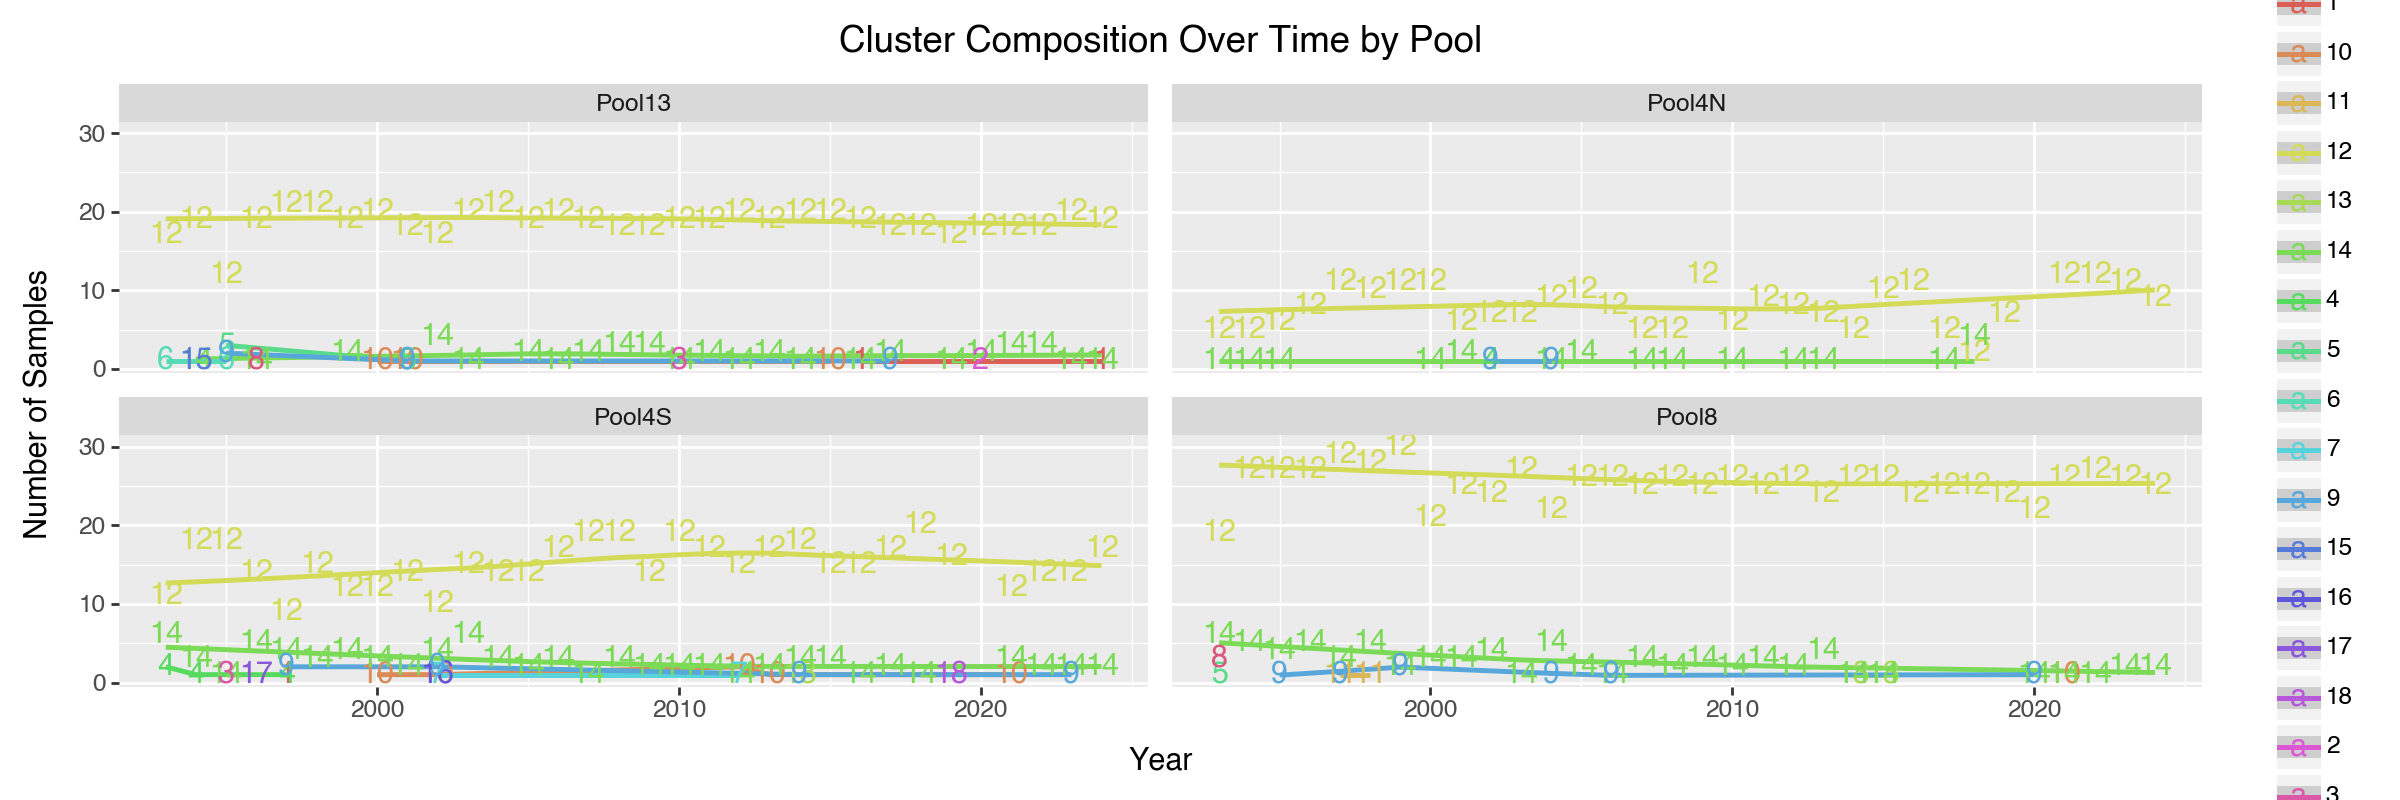

In [55]:
from plotnine import *

# Count samples per year per cluster
cluster_time = df_explore.groupby(['year', 'cluster']).size().reset_index(name='count')
cluster_time['cluster'] = cluster_time['cluster'].astype(str)

# Create the plot (no CI for smooth)
(ggplot(cluster_time, aes(x='year', y='count', color='cluster')) +
 geom_line() +
 geom_point() +
 labs(x='Year', y='Number of Samples', color='Cluster', title='Cluster Composition Over Time') +
 scale_y_log10()
 )

# Count samples per year per cluster per pool
cluster_time_pool = df_explore.groupby(['year', 'cluster', 'mode_pool']).size().reset_index(name='count')
cluster_time_pool['cluster'] = cluster_time_pool['cluster'].astype(str)

# Only smooth groups with >= 2 points
grp_size = cluster_time_pool.groupby(['mode_pool', 'cluster'])['year'].transform('size')
cluster_time_pool_smooth = cluster_time_pool[grp_size >= 2]

# Faceted plot with smoothing (disable CI)
(ggplot(cluster_time_pool, aes(x='year', y='count', color='cluster')) +
 geom_line() +
 geom_point() +
 geom_smooth(data=cluster_time_pool_smooth, method='lm', se=False) +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Number of Samples', color='Cluster', title='Cluster Composition Over Time by Pool')
 )

# Filter out a cluster and plot with labels, smoothing only for groups with >= 2 points
filtered = cluster_time_pool.query('cluster != "19"')
grp_size2 = filtered.groupby(['mode_pool', 'cluster'])['year'].transform('size')
filtered_smooth = filtered[grp_size2 >= 2]

(ggplot(filtered, aes(x='year', y='count', color='cluster')) +
 geom_point() +
 geom_text(aes(label='cluster')) +
 geom_smooth(data=filtered_smooth, method='lm', se=False) +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Number of Samples', color='Cluster', title='Cluster Composition Over Time by Pool') +
 theme(figure_size=(12, 4))
 )
 
# Create the plot with faceting by pool
(ggplot(cluster_time_pool.query('cluster != "19"'), aes(x='year', y='count', color='cluster')) +
# geom_line() +
 #geom_point() +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Number of Samples', color='Cluster', 
    title='Cluster Composition Over Time by Pool') +
geom_smooth() +
geom_text(aes(label='cluster')) +
 #scale_y_log10() +
 theme(figure_size=(12, 4))  # width=12, height=4 inches
 )